# using the CapsLayer module

In [1]:
import numpy as np
import tensorflow as tf
import os
import struct
import matplotlib.pyplot as plt
from layers.CapsLayer import CapsLayer
from layers.ConvCapsLayer import ConvCapsLayer
from layers.ConvLayer import ConvLayer
from layers.DenseLayer import DenseLayer

/home/luke/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
class MNIST():
    def __init__(self, directory):
        self._directory = directory
        
        self._training_data = self._load_binaries("./train-images.idx3-ubyte")
        self._training_labels = self._load_binaries("./train-labels.idx1-ubyte")
        self._test_data = self._load_binaries("./t10k-images.idx3-ubyte")
        self._test_labels = self._load_binaries("./t10k-labels.idx1-ubyte")
        
        np.random.seed(0)
        samples_n = self._training_labels.shape[0]
        random_indices = np.random.choice(samples_n, samples_n // 10, replace = False)
        np.random.seed()
        
        self._validation_data = self._training_data[random_indices]
        self._validation_labels = self._training_labels[random_indices]
        self._training_data = np.delete(self._training_data, random_indices, axis = 0)
        self._training_labels = np.delete(self._training_labels, random_indices)
    
    def _load_binaries(self, file_name):
        path = os.path.join(self._directory, file_name)
        
        with open(path, 'rb') as fd:
            check, items_n = struct.unpack(">ii", fd.read(8))

            if "images" in file_name and check == 2051:
                height, width = struct.unpack(">II", fd.read(8))
                images = np.fromfile(fd, dtype = 'uint8')
                return np.reshape(images, (items_n, height, width))
            elif "labels" in file_name and check == 2049:
                return np.fromfile(fd, dtype = 'uint8')
            else:
                raise ValueError("Not a MNIST file: " + path)
    
    
    def get_training_batch(self, batch_size):
        return self._get_batch(self._training_data, self._training_labels, batch_size)
    
    def get_validation_batch(self, batch_size):
        return self._get_batch(self._validation_data, self._validation_labels, batch_size)
    
    def get_test_batch(self, batch_size):
        return self._get_batch(self._test_data, self._test_labels, batch_size)
    
    def _get_batch(self, data, labels, batch_size):
        samples_n = labels.shape[0]
        if batch_size <= 0:
            batch_size = samples_n
        
        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        data = data[random_indices]
        labels = labels[random_indices]
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off], labels[on:off]
    
    
    def get_sizes(self):
        training_samples_n = self._training_labels.shape[0]
        validation_samples_n = self._validation_labels.shape[0]
        test_samples_n = self._test_labels.shape[0]
        return training_samples_n, validation_samples_n, test_samples_n

In [3]:
#STORING THE DATA
mnist_data = MNIST('/home/luke/data/mnist/')

In [4]:
#INVESTIGATING THE DATA
'''
for i, batch in enumerate(mnist_data.get_training_batch(1)):
    print(batch)
    if i > 1:
        break
'''       


'\nfor i, batch in enumerate(mnist_data.get_training_batch(1)):\n    print(batch)\n    if i > 1:\n        break\n'

In [12]:
#HYPERPARAMETERS

#TRAINING PARAMS
batch_size = 128


In [13]:
def mask_and_flatten_digit_caps(digit_caps, labels):
    
    labels = tf.one_hot(labels, depth=10)
    print(labels.get_shape())
    labels = tf.expand_dims(labels, axis=-1)
    print(labels.get_shape())
    labels = tf.tile(labels, [1,1,16])
    print(labels.get_shape())
    masked_digit_caps = digit_caps * labels
    print(masked_digit_caps.get_shape())
    masked_and_flat = tf.reshape(masked_digit_caps, shape=[batch_size,10*16])
    print(masked_and_flat)
    return tf.reshape(masked_digit_caps, shape=[batch_size,10*16]) 



def calculate_loss_accuracy(digit_caps, labels):
    
    length_digit_caps = tf.norm(digit_caps, axis = 2)
    labels_one_hot = tf.one_hot(labels, depth=10)
    
   
    plus_loss =  labels_one_hot * tf.nn.relu(0.9 - length_digit_caps)
    minus_loss = 0.5 * (1 - labels_one_hot) * \
                        tf.nn.relu(length_digit_caps - 0.1)
    
    loss = tf.reduce_sum(plus_loss + minus_loss, axis=-1)
    loss = tf.reduce_mean(loss)
    
    correct_prediction = tf.equal(tf.argmax(length_digit_caps, 1), labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return loss, accuracy


def calculate_reconstruction_loss(reconstructions, images):
    
    images = images/255.0
    images_flatten = tf.reshape(images, shape=[batch_size, 784])
    squared_error = tf.squared_difference(reconstructions, images_flatten)
    sse = tf.reduce_sum(squared_error, axis=-1)
    
    return 0.0005 * tf.reduce_mean(sse)
    

In [14]:
#DESCIRBING THE DATAFLOW GRAPH

tf.reset_default_graph()

# define the placeholders
images = tf.placeholder(dtype=tf.float32, shape=[batch_size, 28, 28])
images_exp = tf.expand_dims(images, axis=-1)
labels = tf.placeholder(dtype=tf.int64, shape=[batch_size])


with tf.variable_scope('ReLU_Conv1'):
    conv_layer = ConvLayer(
                    kernel_size = 9,
                    stride = 1,
                    padding = 'VALID',
                    channels = 256,
                    activation_function = 'ReLU' 
                 )
    conv = conv_layer(images_exp)

    
with tf.variable_scope('Primary_Caps'):
    primary_caps_layer = ConvCapsLayer(
                            kernel_size = 9,
                            stride = 2,
                            padding = 'VALID',
                            dimension = 8,
                            channels = 32,
                        )
    primary_caps = primary_caps_layer(conv)

    
with tf.variable_scope('Digit_Caps'):
    digit_caps_layer = CapsLayer(
                            count1 = 6*6*32,
                            dim1 = 8,
                            count2 = 10,
                            dim2 = 16,
                            rout_iter = 3
                        )
    digit_caps = digit_caps_layer(primary_caps)


with tf.variable_scope('Loss'):
    loss, accuracy = calculate_loss_accuracy(digit_caps, labels)
    

#RECONSTRUCTOR

# flatten and mask the digit capsules
digit_caps_flat = mask_and_flatten_digit_caps(digit_caps,
                                                labels
                                                )

with tf.variable_scope('Dense1'):
    dense_1_layer = DenseLayer(
                        n_out = 512,
                        activation_function = 'ReLU'
                    )
    dense_1 = dense_1_layer(digit_caps_flat)
    

with tf.variable_scope('Dense2'):
    dense_2_layer = DenseLayer(
                        n_out = 1024,
                        activation_function = 'ReLU'
                    )
    dense_2 = dense_2_layer(dense_1)

    
with tf.variable_scope('Dense3'):
    dense_3_layer = DenseLayer(
                        n_out = 28*28,
                        activation_function = 'Sigmoid'
                    )
    dense_3 = dense_3_layer(dense_2)
    reconstructions = tf.reshape(dense_3, shape=[batch_size, 28, 28])
    
    
with tf.variable_scope('Reconstruction_Loss'):
    reconstruction_loss = calculate_reconstruction_loss(dense_3, images)
    

with tf.variable_scope('Optimizer'):
    optimizer = tf.train.AdamOptimizer()
    training_step = optimizer.minimize(loss+reconstruction_loss)
    
    


#SUMMARIES
tf.summary.scalar('loss', loss)

merged_summaries = tf.summary.merge_all()
    

(1, 10)
(1, 10, 1)
(1, 10, 16)
(1, 10, 16)
Tensor("Reshape:0", shape=(1, 160), dtype=float32)


Step 1: Loss: 3.237624168395996, Accuracy: 0.0
0.188267
[-0.         -0.          0.          0.         -0.          0.          0.
  0.         -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.          0.         -0.         -0.         -0.
  0.          0.         -0.          0.         -0.          0.          0.
 -0.          0.         -0.          0.          0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.          0.
  0.         -0.          0.         -0.         -0.         -0.          0.
 -0.          0.         -0.         -0.         -0.          0.          0.
  0.         -0.          0.          0.         -0.          0.          0.
  0.          0.          0.         -0.          0.          0.         -0.
 -0.          0.          0.         -0.         -0.         -0.         -0.
  0.         -0.          0.         -0.          0.          0.         -0.
 -0.         -0.    

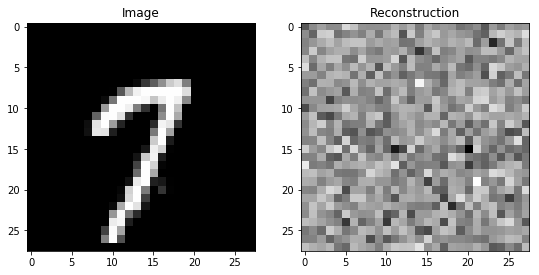

Step 2: Loss: 3.3558950424194336, Accuracy: 0.0
0.0948629
[-0.          0.          0.         -0.          0.          0.         -0.
 -0.          0.         -0.          0.          0.          0.          0.
  0.          0.         -0.54116535 -0.40748942  0.22316466  0.10218916
 -0.04016779 -0.26567593 -0.09662098  0.23591393 -0.05797745  0.06263044
 -0.16774629 -0.23626405  0.10034631 -0.18697695 -0.14329781 -0.0824522  -0.
 -0.          0.          0.         -0.          0.         -0.          0.
 -0.         -0.          0.          0.         -0.          0.         -0.
  0.          0.          0.         -0.          0.          0.         -0.
  0.          0.         -0.         -0.         -0.         -0.         -0.
 -0.          0.         -0.         -0.          0.          0.          0.
 -0.         -0.          0.         -0.         -0.          0.         -0.
  0.          0.          0.         -0.         -0.          0.         -0.
 -0.         -0.          

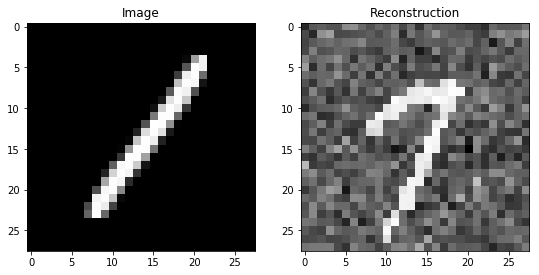

Step 3: Loss: 3.5948784351348877, Accuracy: 0.0
0.025307
[-0.          0.          0.         -0.          0.         -0.         -0.
  0.          0.          0.          0.         -0.          0.          0.
  0.         -0.         -0.         -0.          0.          0.         -0.
 -0.         -0.          0.         -0.          0.         -0.         -0.
  0.         -0.          0.         -0.         -0.         -0.          0.
  0.          0.          0.          0.          0.          0.         -0.
 -0.          0.         -0.          0.          0.          0.          0.
 -0.         -0.          0.          0.          0.         -0.         -0.
  0.          0.         -0.         -0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.          0.
  0.         -0.          0.         -0.          0.         -0.         -0.
 -0.          0.          0.          0.         -0.         -0.         -0.
  0.          0.   

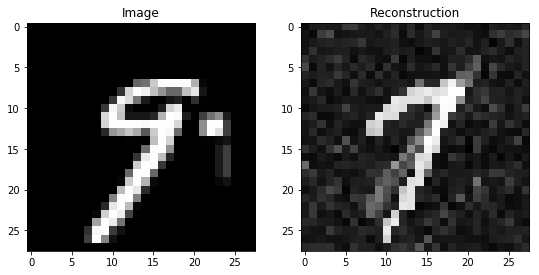

Step 4: Loss: 3.4117536544799805, Accuracy: 1.0
0.0168836
[ 0.          0.          0.          0.          0.         -0.          0.
  0.          0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.          0.         -0.
 -0.         -0.          0.         -0.          0.         -0.         -0.
  0.         -0.          0.         -0.          0.         -0.          0.
 -0.          0.          0.          0.          0.          0.         -0.
 -0.          0.         -0.          0.          0.          0.         -0.
 -0.         -0.          0.          0.          0.         -0.         -0.
 -0.          0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.         -0.          0.         -0.          0.
  0.         -0.         -0.         -0.          0.         -0.         -0.
 -0.          0.          0.          0.         -0.         -0.         -0.
  0.          0.  

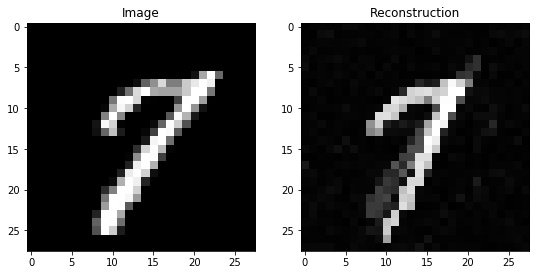

Step 5: Loss: 3.464419364929199, Accuracy: 0.0
0.0439738
[ 0.         -0.          0.          0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.          0.          0.
  0.          0.         -0.         -0.          0.          0.          0.
 -0.         -0.          0.         -0.          0.         -0.         -0.
  0.         -0.          0.         -0.          0.         -0.         -0.
  0.          0.          0.          0.          0.          0.          0.
 -0.          0.          0.         -0.         -0.         -0.          0.
 -0.         -0.          0.          0.          0.         -0.         -0.
  0.          0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.          0.         -0.         -0.
 -0.          0.          0.          0.         -0.         -0.         -0.
  0.         -0.   

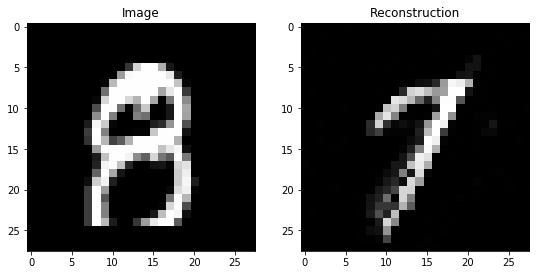

Step 6: Loss: 3.277822494506836, Accuracy: 1.0
0.0273238
[-0.         -0.         -0.         -0.         -0.          0.          0.
 -0.         -0.          0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.         -0.          0.          0.          0.
 -0.         -0.          0.          0.          0.         -0.         -0.
  0.         -0.          0.         -0.         -0.          0.          0.
  0.         -0.         -0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.          0.         -0.         -0.
  0.          0.         -0.         -0.          0.          0.         -0.
 -0.          0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.         -0.          0.          0.         -0.
 -0.          0.          0.          0.         -0.          0.          0.
  0.         -0.   

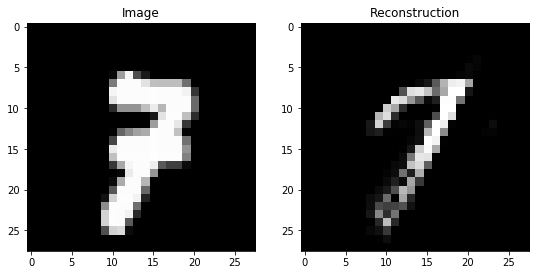

Step 7: Loss: 3.122748374938965, Accuracy: 0.0
0.0192742
[-0.         -0.         -0.         -0.         -0.          0.          0.
 -0.         -0.          0.          0.          0.         -0.         -0.
  0.         -0.         -0.         -0.          0.          0.          0.
 -0.         -0.          0.         -0.          0.         -0.         -0.
  0.         -0.          0.         -0.         -0.          0.          0.
 -0.         -0.         -0.         -0.         -0.         -0.         -0.
  0.         -0.          0.          0.          0.          0.         -0.
 -0.         -0.         -0.          0.          0.         -0.         -0.
 -0.          0.         -0.         -0.          0.          0.         -0.
 -0.          0.         -0.         -0.         -0.         -0.          0.
  0.         -0.          0.         -0.          0.          0.         -0.
  0.          0.          0.          0.         -0.          0.          0.
  0.         -0.   

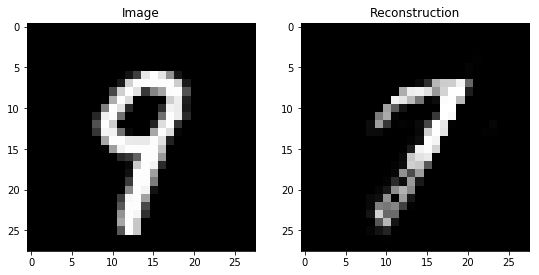

Step 8: Loss: 3.38175892829895, Accuracy: 0.0
0.0565295
[-0.         -0.          0.          0.         -0.          0.         -0.
  0.          0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.          0.          0.
 -0.          0.          0.          0.          0.         -0.         -0.
  0.         -0.          0.          0.         -0.22892241  0.15788826
 -0.00703618 -0.03873239 -0.0435926  -0.10195063  0.16139862  0.17578973
 -0.04462204  0.48425213  0.13987216  0.02365268  0.03822143 -0.12169777
  0.3570441  -0.04371215  0.         -0.          0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.          0.          0.
  0.          0.          0.         -0.          0.         -0.          0.
 -0.          0.          0.         -0.          0.          0.         -0.
 -0.         -0.         -0.          0.         -0.          0.         -0.
  0.         -0.         -0.    

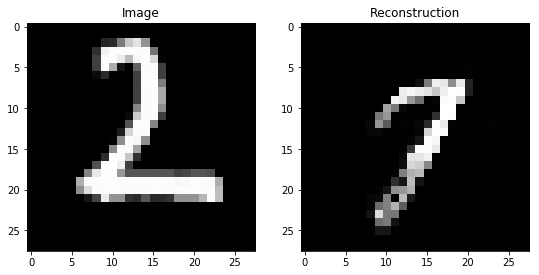

Step 9: Loss: 3.3643288612365723, Accuracy: 0.0
0.0227764
[-0.         -0.         -0.         -0.         -0.          0.         -0.
  0.          0.          0.          0.          0.         -0.         -0.
  0.         -0.         -0.49504128 -0.49557269  0.22526957  0.14110722
  0.05313801 -0.24835078  0.01308698  0.21492243 -0.01990815  0.17219982
 -0.23868136 -0.11240188  0.16843811 -0.28570873  0.07016244 -0.04658637
 -0.          0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.          0.          0.         -0.
  0.          0.         -0.          0.          0.          0.         -0.
 -0.          0.          0.         -0.         -0.          0.          0.
 -0.         -0.          0.         -0.          0.         -0.         -0.
 -0.          0.          0.         -0.         -0.          0.         -0.
  0.         -0.         -0.         -0.          0.          0.         -0.
  0.         -0.          0.  

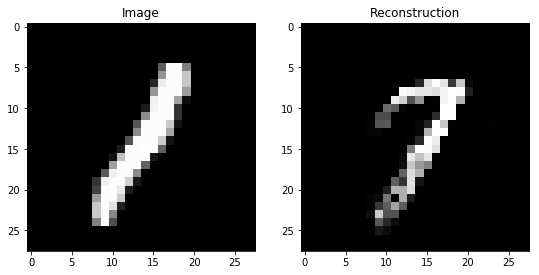

Step 10: Loss: 3.3678977489471436, Accuracy: 0.0
0.0336253
[-0.         -0.         -0.         -0.         -0.          0.         -0.
  0.         -0.         -0.          0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.          0.          0.
 -0.          0.          0.          0.          0.         -0.         -0.
  0.         -0.          0.         -0.         -0.          0.          0.
 -0.          0.         -0.          0.          0.         -0.          0.
  0.          0.         -0.         -0.          0.          0.          0.
 -0.         -0.         -0.          0.         -0.          0.          0.
  0.         -0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.          0.          0.         -0.
 -0.          0.         -0.         -0.         -0.          0.          0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
 -0.          0. 

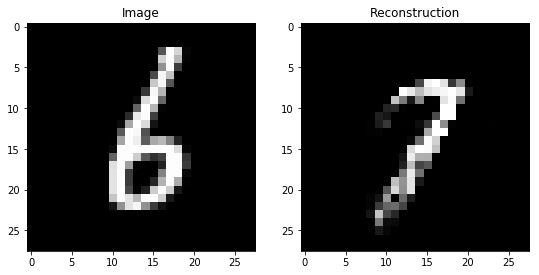

Step 11: Loss: 3.1654107570648193, Accuracy: 1.0
0.0306682
[-0.          0.         -0.         -0.         -0.          0.         -0.
  0.          0.         -0.          0.          0.         -0.         -0.
  0.         -0.         -0.         -0.          0.          0.          0.
 -0.          0.          0.         -0.          0.         -0.         -0.
  0.         -0.          0.         -0.         -0.          0.          0.
  0.         -0.         -0.          0.          0.         -0.          0.
  0.          0.         -0.          0.          0.          0.          0.
 -0.         -0.          0.          0.          0.         -0.         -0.
  0.         -0.         -0.         -0.         -0.          0.         -0.
 -0.         -0.          0.         -0.          0.          0.          0.
 -0.         -0.         -0.          0.         -0.          0.          0.
 -0.         -0.         -0.         -0.          0.         -0.         -0.
 -0.          0. 

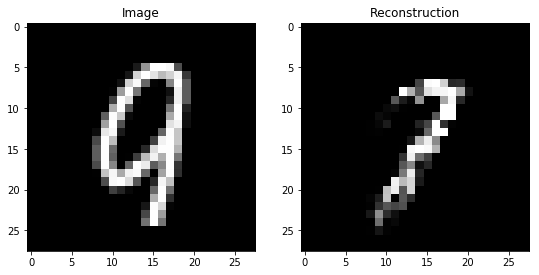

Step 12: Loss: 3.2636914253234863, Accuracy: 0.0
0.0268097
[-0.          0.         -0.          0.         -0.         -0.          0.
 -0.          0.         -0.          0.          0.          0.          0.
  0.          0.         -0.44731319 -0.56505519  0.25036633  0.20933007
  0.07413619 -0.15751047  0.00507532  0.04320011 -0.03236747  0.10045283
 -0.1384654  -0.11143668  0.14831619 -0.33325675  0.16788222 -0.00845227
 -0.         -0.         -0.          0.         -0.         -0.          0.
  0.         -0.          0.         -0.          0.         -0.         -0.
  0.          0.         -0.          0.          0.         -0.          0.
  0.          0.         -0.         -0.          0.         -0.         -0.
 -0.         -0.         -0.          0.         -0.          0.         -0.
  0.         -0.          0.          0.         -0.         -0.          0.
 -0.          0.          0.         -0.          0.         -0.         -0.
  0.         -0.         -0. 

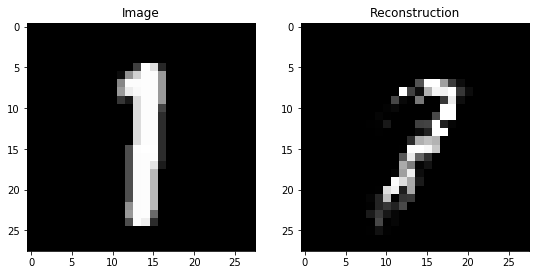

Step 13: Loss: 3.2168397903442383, Accuracy: 0.0
0.0184092
[ 0.         -0.          0.          0.          0.         -0.          0.
 -0.          0.          0.         -0.         -0.          0.          0.
  0.          0.         -0.47860065 -0.5585928   0.1764245   0.04554316
  0.02823386 -0.23419896 -0.06497506  0.13658588 -0.02396779 -0.00196082
 -0.20620768 -0.02808473  0.14350478 -0.3162998   0.08426782  0.01386299
 -0.          0.         -0.          0.          0.         -0.          0.
  0.         -0.          0.         -0.          0.         -0.         -0.
  0.          0.         -0.         -0.          0.          0.          0.
  0.         -0.         -0.         -0.          0.         -0.         -0.
  0.         -0.         -0.          0.          0.         -0.         -0.
  0.         -0.          0.         -0.         -0.          0.         -0.
  0.         -0.         -0.          0.          0.          0.         -0.
  0.          0.         -0. 

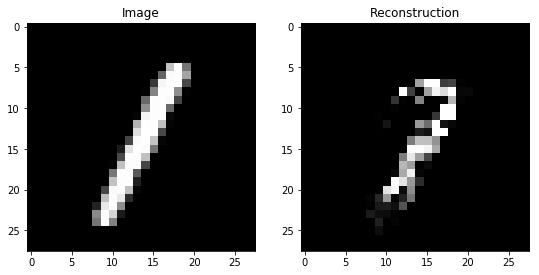

Step 14: Loss: 2.8812365531921387, Accuracy: 0.0
0.0390315
[ 0.          0.          0.          0.          0.         -0.          0.
 -0.          0.         -0.         -0.          0.          0.          0.
 -0.          0.         -0.         -0.          0.          0.         -0.
 -0.         -0.          0.         -0.          0.         -0.         -0.
  0.         -0.          0.          0.         -0.21972443  0.01941051
  0.00118016  0.11215346 -0.0586526  -0.17494033  0.33986604  0.3194778
 -0.13032371  0.60355705  0.01838149  0.25110897 -0.03586183 -0.01481817
  0.30306625  0.03002716 -0.          0.          0.          0.          0.
  0.         -0.         -0.         -0.          0.          0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.          0.
  0.         -0.          0.          0.         -0.          0.         -0.
  0.         -0.          0.          0.         -0.          0.         -0.
 -0.          0.          0.  

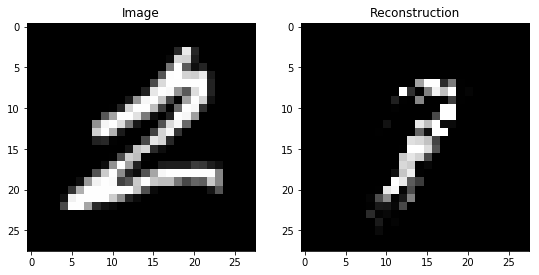

Step 15: Loss: 2.9127771854400635, Accuracy: 0.0
0.0524529
[ 0.          0.         -0.         -0.          0.         -0.         -0.
  0.         -0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.          0.          0.
 -0.         -0.         -0.         -0.          0.         -0.         -0.
  0.         -0.          0.          0.         -0.         -0.          0.
  0.         -0.         -0.          0.          0.         -0.          0.
 -0.          0.         -0.          0.          0.          0.         -0.
  0.          0.          0.         -0.          0.          0.          0.
 -0.          0.          0.         -0.          0.         -0.          0.
 -0.         -0.          0.          0.         -0.         -0.         -0.
 -0.          0.         -0.          0.          0.         -0.          0.
  0.         -0.         -0.         -0.         -0.          0.         -0.
  0.          0. 

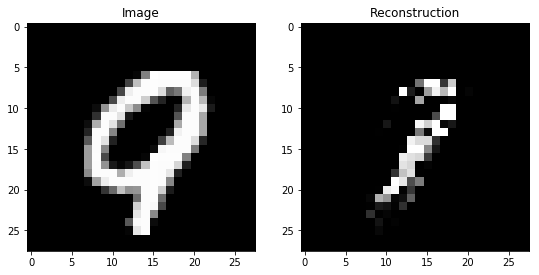

Step 16: Loss: 3.3518714904785156, Accuracy: 0.0
0.0576258
[ 0.15075123 -0.12264388 -0.03071262 -0.10500926  0.02853556  0.08847948
 -0.04163276 -0.03912104 -0.11104214  0.07809445 -0.16698763 -0.18443987
 -0.0686627  -0.24186139 -0.26950675 -0.08069193 -0.         -0.          0.
  0.         -0.         -0.         -0.         -0.          0.          0.
 -0.         -0.          0.         -0.          0.          0.         -0.
 -0.          0.          0.         -0.         -0.          0.          0.
 -0.          0.         -0.          0.         -0.         -0.          0.
  0.         -0.          0.          0.          0.         -0.          0.
 -0.          0.         -0.          0.          0.         -0.          0.
 -0.          0.         -0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.          0.         -0.         -0.          0.
  0.         -0.         -0.          0.         -0.          0.          0.
 -0.          0.         

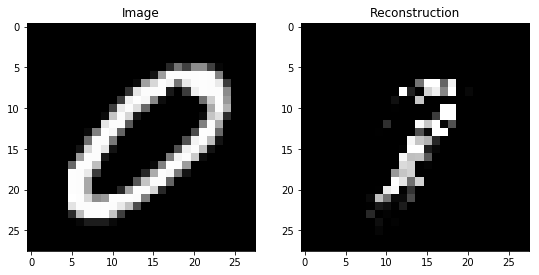

Step 17: Loss: 3.059835910797119, Accuracy: 0.0
0.0407114
[ 0.         -0.         -0.         -0.          0.          0.         -0.
  0.         -0.          0.         -0.         -0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.          0.         -0.         -0.          0.
  0.         -0.         -0.          0.         -0.         -0.         -0.
  0.         -0.         -0.          0.          0.         -0.          0.
 -0.          0.         -0.         -0.          0.          0.         -0.
  0.          0.         -0.         -0.         -0.         -0.          0.
  0.          0.          0.         -0.          0.          0.          0.
  0.          0.         -0.         -0.         -0.          0.         -0.
 -0.          0.         -0.         -0.         -0.          0.         -0.
  0.          0.         -0.          0.          0.         -0.          0.
 -0.         -0.  

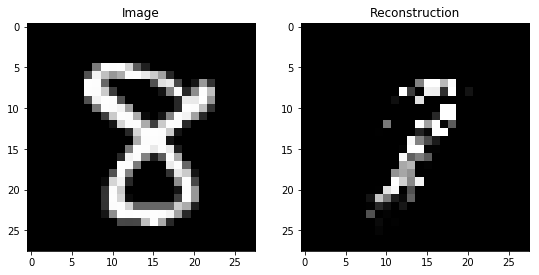

Step 18: Loss: 2.849468231201172, Accuracy: 0.0
0.0463201
[ 0.06420471 -0.17585032 -0.06382579 -0.25834677  0.04293684  0.2082254
 -0.03280998  0.02879398 -0.3230167   0.16532823 -0.06077117 -0.27283099
 -0.00046087 -0.40600625 -0.39622617 -0.21341358 -0.         -0.         -0.
 -0.         -0.         -0.          0.          0.          0.          0.
  0.          0.         -0.         -0.         -0.          0.         -0.
 -0.          0.          0.         -0.         -0.          0.          0.
 -0.          0.         -0.          0.         -0.         -0.          0.
  0.          0.          0.          0.         -0.         -0.         -0.
  0.         -0.         -0.         -0.          0.          0.          0.
 -0.          0.          0.          0.         -0.         -0.          0.
  0.         -0.         -0.          0.          0.          0.         -0.
  0.         -0.          0.          0.         -0.          0.          0.
 -0.          0.          0

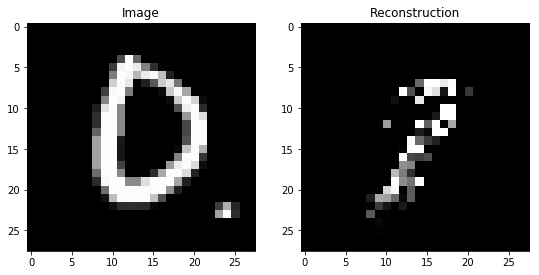

Step 19: Loss: 3.357346773147583, Accuracy: 0.0
0.0584545
[ 0.         -0.         -0.         -0.          0.          0.         -0.
  0.         -0.          0.         -0.         -0.          0.         -0.
 -0.         -0.          0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.         -0.         -0.         -0.
  0.          0.          0.         -0.         -0.         -0.          0.
  0.          0.         -0.          0.          0.         -0.          0.
 -0.          0.         -0.         -0.          0.          0.          0.109667
 -0.16504461 -0.12705797  0.06947313  0.00050628  0.08220586  0.00176995
 -0.06109914  0.09771471 -0.1132813  -0.06781989  0.15554599 -0.03750207
  0.15340617 -0.13289437 -0.09133599  0.         -0.         -0.          0.
  0.          0.         -0.          0.          0.         -0.         -0.
  0.         -0.          0.         -0.          0.          0.         -0.
 -0.          0.    

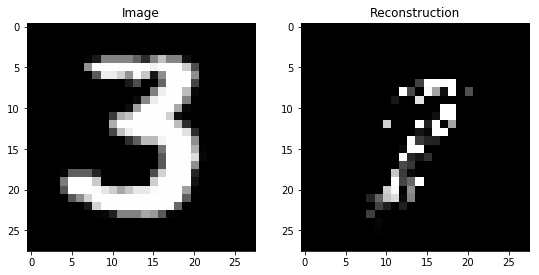

Step 20: Loss: 3.292080879211426, Accuracy: 0.0
0.0388745
[ 0.         -0.         -0.         -0.          0.          0.         -0.
  0.         -0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.          0.         -0.
 -0.          0.         -0.         -0.          0.         -0.         -0.
  0.         -0.          0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.          0.          0.          0.          0.
 -0.          0.         -0.          0.          0.          0.          0.
 -0.         -0.          0.          0.          0.          0.         -0.
  0.         -0.         -0.          0.         -0.          0.         -0.
 -0.          0.         -0.         -0.          0.          0.          0.
  0.         -0.          0.          0.         -0.          0.         -0.
 -0.         -0.         -0.          0.12840557 -0.16823572 -0.06642295
  0.16096726 -0.090319

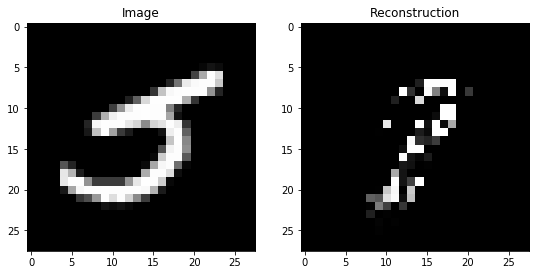

Step 21: Loss: 2.8101558685302734, Accuracy: 1.0
0.0370271
[ 0.         -0.         -0.         -0.          0.          0.          0.
 -0.         -0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.          0.         -0.          0.         -0.
  0.          0.          0.         -0.         -0.          0.          0.
 -0.          0.         -0.         -0.         -0.         -0.          0.
  0.         -0.         -0.          0.          0.         -0.          0.
  0.          0.         -0.         -0.          0.          0.          0.
 -0.         -0.          0.          0.          0.         -0.         -0.
  0.         -0.         -0.          0.         -0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.          0.          0.         -0.          0.
  0.         -0.          0.          0.         -0.         -0.          0.
 -0.         -0. 

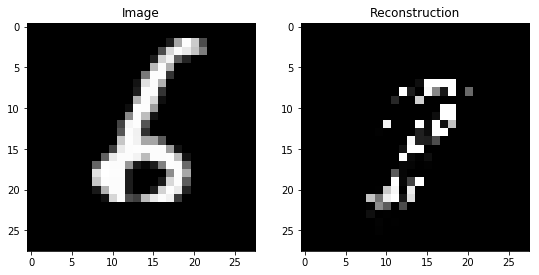

Step 22: Loss: 3.620955467224121, Accuracy: 0.0
0.0364588
[-0.         -0.         -0.         -0.         -0.          0.         -0.
 -0.         -0.          0.         -0.         -0.          0.         -0.
 -0.         -0.          0.          0.         -0.          0.          0.
 -0.          0.          0.          0.          0.          0.         -0.
 -0.         -0.         -0.          0.         -0.         -0.         -0.
  0.         -0.         -0.          0.          0.         -0.          0.
 -0.          0.         -0.          0.          0.          0.          0.
 -0.         -0.          0.          0.          0.         -0.         -0.
  0.         -0.         -0.          0.         -0.          0.         -0.
 -0.          0.06190724  0.13012441  0.05361034  0.02582701  0.04800685
  0.04104746 -0.08628638  0.0153345  -0.03763802 -0.01133684  0.01909896
  0.00462515  0.03578239 -0.03083748 -0.02156964  0.04992286 -0.         -0.
 -0.          0.         -

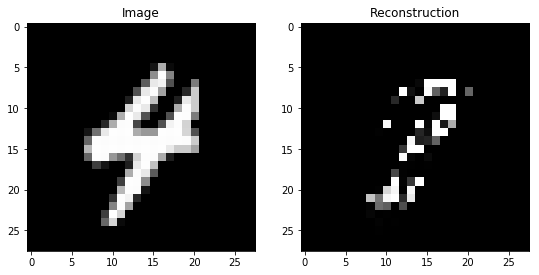

Step 23: Loss: 2.7807788848876953, Accuracy: 0.0
0.0494334
[ 0.01432124 -0.33290601 -0.14925507 -0.3139002  -0.05932219  0.28626922
 -0.02757182 -0.00564524 -0.3325958   0.19739109 -0.13101976 -0.28580114
 -0.03237711 -0.33557028 -0.35250288 -0.27682909  0.          0.          0.
  0.          0.          0.         -0.         -0.         -0.          0.
  0.          0.         -0.         -0.         -0.         -0.         -0.
 -0.          0.          0.         -0.         -0.          0.          0.
 -0.          0.          0.          0.         -0.          0.          0.
 -0.          0.         -0.         -0.          0.          0.          0.
 -0.         -0.          0.         -0.         -0.          0.         -0.
  0.         -0.         -0.         -0.          0.          0.         -0.
  0.          0.         -0.          0.         -0.         -0.          0.
 -0.          0.         -0.          0.          0.         -0.         -0.
  0.          0.         

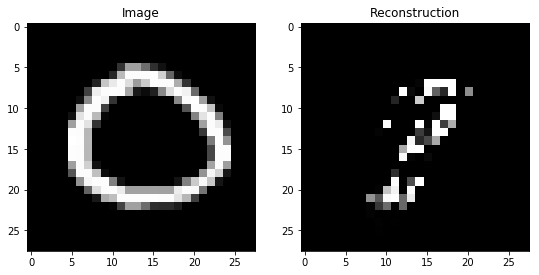

Step 24: Loss: 2.6770718097686768, Accuracy: 0.0
0.0540024
[-0.         -0.         -0.         -0.         -0.          0.         -0.
  0.         -0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.          0.          0.          0.          0.
  0.         -0.          0.         -0.          0.         -0.          0.
  0.         -0.         -0.         -0.         -0.         -0.          0.
  0.         -0.         -0.          0.          0.         -0.          0.
 -0.          0.         -0.          0.          0.          0.          0.
 -0.         -0.          0.          0.          0.         -0.         -0.
  0.         -0.         -0.          0.         -0.          0.         -0.
 -0.          0.12729698  0.5112254   0.34476838  0.12912995  0.22142206
  0.17560989 -0.140628    0.00623699 -0.03451147 -0.18751343  0.00514922
 -0.07636853  0.26962301 -0.20916763 -0.03060247  0.20600258 -0.         -0.
 -0.          0.         

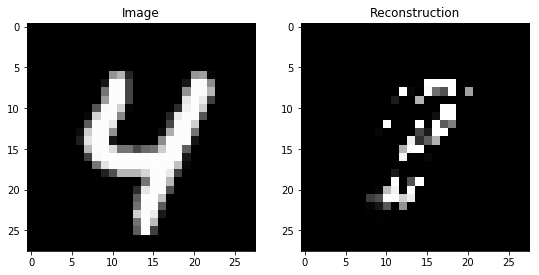

Step 25: Loss: 3.0753049850463867, Accuracy: 0.0
0.0420512
[ 0.         -0.         -0.         -0.         -0.          0.         -0.
  0.         -0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.          0.          0.         -0.          0.
 -0.         -0.          0.          0.         -0.         -0.          0.
  0.         -0.         -0.         -0.         -0.14278176 -0.1198532
 -0.0471789   0.01374175  0.03851644 -0.00444605  0.2171731   0.33758637
 -0.01176704  0.73886734 -0.00743543  0.10430574 -0.0709407  -0.00426632
  0.26072803 -0.03367942  0.         -0.         -0.          0.          0.
  0.         -0.         -0.          0.         -0.         -0.          0.
 -0.          0.         -0.         -0.          0.          0.          0.
  0.          0.          0.         -0.          0.         -0.         -0.
  0.         -0.          0.         -0.          0.          0.         -0.
 -0.         -0.          0.  

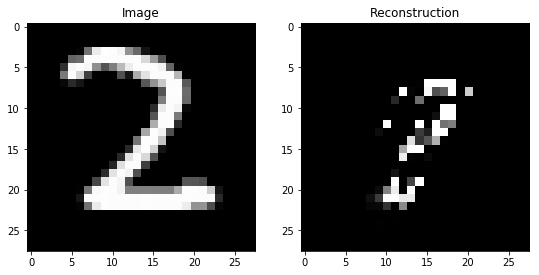

Step 26: Loss: 2.980405807495117, Accuracy: 0.0
0.0497079
[ 0.         -0.         -0.         -0.          0.          0.          0.
 -0.         -0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.          0.          0.         -0.         -0.          0.
  0.          0.          0.          0.         -0.         -0.         -0.
  0.         -0.         -0.          0.          0.         -0.          0.
 -0.          0.         -0.          0.          0.          0.          0.
 -0.         -0.          0.          0.          0.         -0.         -0.
  0.         -0.         -0.          0.         -0.          0.         -0.
 -0.          0.02915066  0.52217722  0.3940753   0.1338916   0.23241007
  0.1796169  -0.17559125  0.15038046 -0.11672568 -0.19140415  0.05741742
 -0.02259136  0.24484767 -0.29925749 -0.13376102  0.2128242  -0.         -0.
 -0.          0.         -

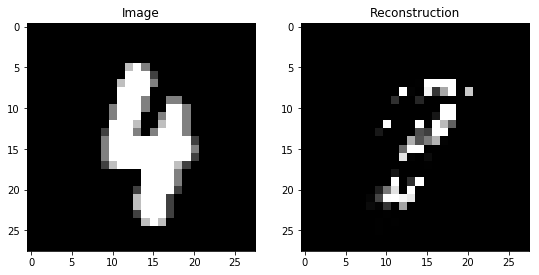

Step 27: Loss: 2.8505330085754395, Accuracy: 0.0
0.0521965
[ 0.04950068 -0.38139716 -0.16543415 -0.27099097  0.01742083  0.28019699
 -0.00241572 -0.07349893 -0.3117826   0.20816645 -0.15145987 -0.30151629
  0.00653652 -0.32968527 -0.35914731 -0.30525368 -0.          0.         -0.
 -0.         -0.          0.         -0.         -0.          0.         -0.
 -0.         -0.          0.          0.          0.          0.         -0.
 -0.          0.         -0.         -0.          0.          0.          0.
 -0.          0.         -0.          0.         -0.          0.          0.
 -0.          0.         -0.         -0.          0.          0.          0.
 -0.         -0.          0.         -0.         -0.          0.         -0.
  0.         -0.         -0.          0.          0.          0.          0.
  0.          0.         -0.          0.         -0.         -0.          0.
 -0.          0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         

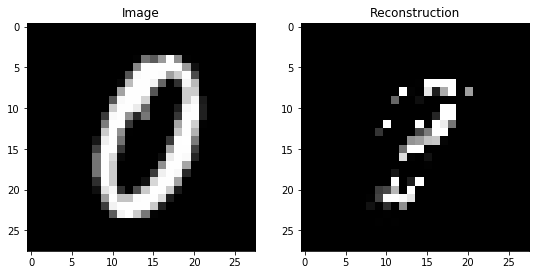

Step 28: Loss: 3.7554187774658203, Accuracy: 0.0
0.0468302
[ 0.         -0.         -0.         -0.          0.          0.         -0.
  0.         -0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.         -0.
 -0.          0.         -0.         -0.          0.          0.         -0.
 -0.          0.          0.          0.         -0.         -0.          0.
 -0.          0.          0.          0.          0.         -0.          0.
 -0.          0.         -0.         -0.          0.         -0.          0.
 -0.         -0.          0.          0.          0.         -0.         -0.
  0.         -0.         -0.          0.         -0.          0.         -0.
 -0.          0.          0.          0.          0.          0.          0.
 -0.          0.         -0.         -0.          0.         -0.          0.
 -0.         -0.          0.         -0.         -0.         -0.          0.
  0.         -0. 

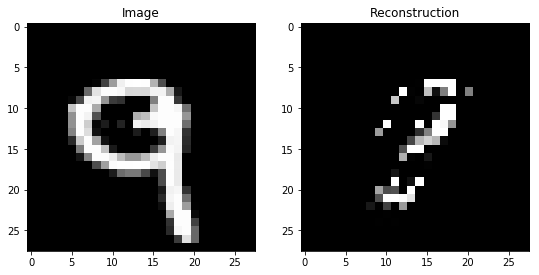

Step 29: Loss: 2.9671173095703125, Accuracy: 0.0
0.0335633
[-0.         -0.         -0.         -0.         -0.          0.         -0.
  0.         -0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.          0.         -0.
 -0.          0.          0.         -0.          0.          0.         -0.
 -0.          0.          0.         -0.         -0.         -0.          0.
 -0.          0.         -0.          0.          0.         -0.          0.
 -0.          0.         -0.          0.          0.          0.          0.
 -0.         -0.          0.          0.          0.         -0.         -0.
  0.         -0.         -0.          0.         -0.          0.         -0.
 -0.          0.02799299  0.50229961  0.43628395  0.12035367  0.2324748
  0.18683921 -0.17847244  0.13112898 -0.1178223  -0.22801115  0.07196191
 -0.03212357  0.27872252 -0.33248779 -0.12112692  0.19085148 -0.          0.
 -0.         -0.          

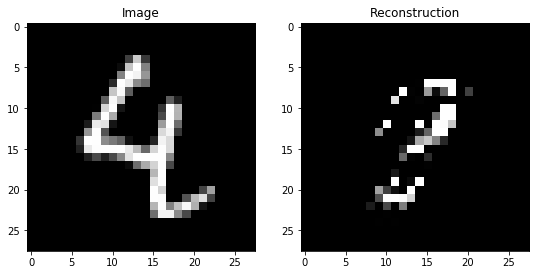

Step 30: Loss: 2.9448800086975098, Accuracy: 0.0
0.043226
[-0.         -0.         -0.         -0.         -0.          0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.          0.          0.          0.
 -0.          0.          0.         -0.          0.          0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.          0.          0.          0.          0.
 -0.          0.         -0.          0.          0.         -0.          0.
 -0.         -0.          0.          0.          0.         -0.         -0.
  0.         -0.         -0.          0.         -0.          0.         -0.
 -0.          0.05287169  0.50378406  0.42509571  0.17168681  0.24663337
  0.22062038 -0.16932726  0.12665106 -0.14497714 -0.20295839  0.04120491
 -0.01464437  0.27452037 -0.32839152 -0.13329451  0.18329653  0.          0.
  0.         -0.          

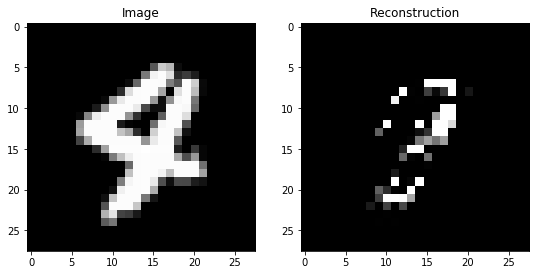

Step 31: Loss: 2.8908724784851074, Accuracy: 1.0
0.0377035
[ 0.         -0.         -0.         -0.         -0.          0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.          0.          0.          0.
  0.         -0.          0.         -0.          0.          0.         -0.
 -0.          0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.          0.          0.          0.         -0.          0.
 -0.         -0.         -0.          0.          0.         -0.          0.
 -0.         -0.          0.          0.          0.         -0.         -0.
  0.         -0.         -0.          0.         -0.          0.         -0.
 -0.          0.          0.          0.          0.          0.          0.
 -0.          0.         -0.         -0.          0.          0.          0.
 -0.         -0.          0.          0.          0.          0.         -0.
 -0.          0. 

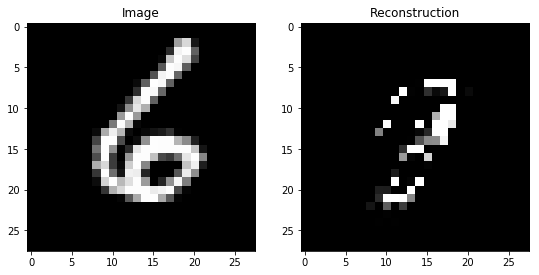

KeyboardInterrupt: 

In [18]:
#train_writer = tf.summary.FileWriter("./summaries/train", tf.get_default_graph())

saver = tf.train.Saver()



with tf.Session() as sess:
    step = 0
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(10):
        batch_generator = mnist_data.get_training_batch(batch_size)
        
        for x, y in batch_generator:
            _loss, _accuracy, _, _rec  = sess.run([loss,
                                            accuracy,
                                            training_step,
                                            reconstructions
                                            ],
                                            feed_dict = {images: x,
                                                        labels: y})
            #train_writer.add_summary(_summaries, step)
            step += 1
            print("Step {}: Loss: {}, Accuracy: {}".format(step, _loss, _accuracy))
            
            '''
            # for validation plot a image and its reconstruction
            fig = plt.figure(figsize = (9,5))
            fig.add_subplot(1,2,1)
            plt.imshow(x[0], cmap='gray')
            plt.title('Image')
            fig.add_subplot(1,2,2)
            plt.imshow(_rec[0], cmap='gray')
            plt.title('Reconstruction')
            plt.show()
            '''
    
    save_path = saver.save(sess, "./tmp/model.ckpt")
            